In [ ]:
# default_exp dewarp

In [ ]:
#export
from ocr.core import plot
import os
import sys
import datetime
import cv2
from PIL import Image
import numpy as np
import scipy.optimize
from functools import partial
import matplotlib.pyplot as plt

In [ ]:
%matplotlib notebook

In [ ]:
#export
dewarp_config = {
    'PAGE_MARGIN_X': 50,       # reduced px to ignore near L/R edge
    'PAGE_MARGIN_Y': 20,       # reduced px to ignore near T/B edge

    'OUTPUT_ZOOM': 1.0,        # how much to zoom output relative to *original* image
    'OUTPUT_DPI': 300,         # just affects stated DPI of PNG, not appearance
    'REMAP_DECIMATE': 16,      # downscaling factor for remapping image

    'ADAPTIVE_WINSZ': 55,      # window size for adaptive threshold in reduced px

    'TEXT_MIN_WIDTH': 15,      # min reduced px width of detected text contour
    'TEXT_MIN_HEIGHT': 2,      # min reduced px height of detected text contour
    'TEXT_MIN_ASPECT': 1.5,    # filter out text contours below this w/h ratio
    'TEXT_MAX_THICKNESS': 10,  # max reduced px thickness of detected text contour

    'EDGE_MAX_OVERLAP': 1.0,   # max reduced px horiz. overlap of contours in span
    'EDGE_MAX_LENGTH': 100.0,  # max reduced px length of edge connecting contours
    'EDGE_ANGLE_COST': 10.0,   # cost of angles in edges (tradeoff vs. length)
    'EDGE_MAX_ANGLE': 7.5,     # maximum change in angle allowed between contours

    'RVEC_IDX': slice(0, 3),   # index of rvec in params vector
    'TVEC_IDX': slice(3, 6),   # index of tvec in params vector
    'CUBIC_IDX': slice(6, 8),  # index of cubic slopes in params vector

    'SPAN_MIN_WIDTH': 30,      # minimum reduced px width for span
    'SPAN_PX_PER_STEP': 20,    # reduced px spacing for sampling along spans

    'DEBUG_LEVEL': 0,          # 0=none, 1=some, 2=lots, 3=all
    'DEBUG_OUTPUT': 'file',    # file, screen, both
    
    'FOCAL_LENGTH': 1.2,       # normalized focal length of camera
    'K': None,
    
    'COLORS': None,
    'WINDOW_NAME': 'Dewarp',   # Window name for visualization
}
    
F = dewarp_config['FOCAL_LENGTH']
dewarp_config['K'] = np.array([
    [F, 0, 0],
    [0, F, 0],
    [0, 0, 1]], dtype=np.float32
)

dewarp_config['CCOLORS'] = [
    (255, 0, 0),
    (255, 63, 0),
    (255, 127, 0),
    (255, 191, 0),
    (255, 255, 0),
    (191, 255, 0),
    (127, 255, 0),
    (63, 255, 0),
    (0, 255, 0),
    (0, 255, 63),
    (0, 255, 127),
    (0, 255, 191),
    (0, 255, 255),
    (0, 191, 255),
    (0, 127, 255),
    (0, 63, 255),
    (0, 0, 255),
    (63, 0, 255),
    (127, 0, 255),
    (191, 0, 255),
    (255, 0, 255),
    (255, 0, 191),
    (255, 0, 127),
    (255, 0, 63),
]

def dewarp_const(f):
    return partial(f, **dewarp_config)

In [ ]:
#export
def round_nearest_multiple(i, factor):
    i = int(i)
    rem = i % factor
    if not rem: return i
    else: return i + factor - rem

In [ ]:
list(range(1,10)), [round_nearest_multiple(10, i) for i in range(1,10)]

([1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 10, 12, 12, 10, 12, 14, 16, 18])

In [ ]:
#export
def pix2norm(shape, pts):
    ''' [3],  '''
    height, width = shape[:2]
    scl = 2.0/(max(height, width))
    offset = np.array([width, height], dtype=pts.dtype).reshape((-1, 1, 2))*0.5
    return (pts - offset) * scl

In [ ]:
#export
def norm2pix(shape, pts, as_integer):
    ''' [3],  '''
    height, width = shape[:2]
    scl = max(height, width)*0.5
    offset = np.array([0.5*width, 0.5*height], dtype=pts.dtype).reshape((-1, 1, 2))
    rval = pts * scl + offset
    if as_integer: return (rval + 0.5).astype(int)
    else: return rval

In [ ]:
#export
def fltp(point):
    ''' [N] -> flatten point tuple '''
    return tuple(point.astype(int).flatten())

In [ ]:
#export
def draw_correspondences(img, dstpoints, projpts):

    display = img.copy()
    dstpoints = norm2pix(img.shape, dstpoints, True)
    projpts = norm2pix(img.shape, projpts, True)

    for pts, color in [(projpts, (255, 0, 0)), (dstpoints, (0, 0, 255))]:
        for point in pts:
            cv2.circle(display, fltp(point), 3, color, -1, cv2.LINE_AA)

    for point_a, point_b in zip(projpts, dstpoints):
        cv2.line(display, fltp(point_a), fltp(point_b), (255, 255, 255), 1, cv2.LINE_AA)

    return display

In [ ]:
#export
def get_default_params(corners, ycoords, xcoords, K, **kwargs):

    # page width and height
    page_width = np.linalg.norm(corners[1] - corners[0])
    page_height = np.linalg.norm(corners[-1] - corners[0])
    rough_dims = (page_width, page_height)

    # our initial guess for the cubic has no slope
    cubic_slopes = [0.0, 0.0]

    # object points of flat page in 3D coordinates
    corners_object3d = np.array([
        [0, 0, 0],
        [page_width, 0, 0],
        [page_width, page_height, 0],
        [0, page_height, 0]])

    # estimate rotation and translation from four 2D-to-3D point correspondences
    _, rvec, tvec = cv2.solvePnP(corners_object3d, corners, K, np.zeros(5))

    span_counts = [len(xc) for xc in xcoords]

    params = np.hstack((np.array(rvec).flatten(),
                        np.array(tvec).flatten(),
                        np.array(cubic_slopes).flatten(),
                        ycoords.flatten()) + tuple(xcoords))

    return rough_dims, span_counts, params

get_default_params = dewarp_const(get_default_params)

In [ ]:
#export
def project_xy(xy_coords, pvec, K, CUBIC_IDX, RVEC_IDX, TVEC_IDX, **kwargs):
    # get cubic polynomial coefficients given
    #  f(0) = 0, f'(0) = alpha
    #  f(1) = 0, f'(1) = beta

    alpha, beta = tuple(pvec[CUBIC_IDX])

    poly = np.array([
        alpha + beta,
        -2*alpha - beta,
        alpha,
        0])

    xy_coords = xy_coords.reshape((-1, 2))
    z_coords = np.polyval(poly, xy_coords[:, 0])

    objpoints = np.hstack((xy_coords, z_coords.reshape((-1, 1))))

    image_points, _ = cv2.projectPoints(objpoints,
                                        pvec[RVEC_IDX],
                                        pvec[TVEC_IDX],
                                        K, np.zeros(5))

    return image_points

project_xy = dewarp_const(project_xy)

In [ ]:
#export
def resize_to_screen(src, maxw=1280, maxh=700, copy=False):

    height, width = src.shape[:2]

    scl_x = float(width)/maxw
    scl_y = float(height)/maxh

    scl = int(np.ceil(max(scl_x, scl_y)))

    if scl > 1.0:
        inv_scl = 1.0/scl
        img = cv2.resize(src, (0, 0), None, inv_scl, inv_scl, cv2.INTER_AREA)
    
    elif copy: img = src.copy()
    else: img = src

    return img

In [ ]:
#export
def box(width, height):
    return np.ones((height, width), dtype=np.uint8)

In [ ]:
#export
def get_page_extents(small, PAGE_MARGIN_X, PAGE_MARGIN_Y, **kwargs):

    height, width = small.shape[:2]

    xmin = PAGE_MARGIN_X
    ymin = PAGE_MARGIN_Y
    xmax = width - PAGE_MARGIN_X
    ymax = height - PAGE_MARGIN_Y

    page = np.zeros((height, width), dtype=np.uint8)
    cv2.rectangle(page, (xmin, ymin), (xmax, ymax), (255, 255, 255), -1)

    outline = np.array([
        [xmin, ymin],
        [xmin, ymax],
        [xmax, ymax],
        [xmax, ymin]])

    return page, outline

get_page_extents = dewarp_const(get_page_extents)

In [ ]:
#export
def interval_measure_overlap(int_a, int_b):
    return min(int_a[1], int_b[1]) - max(int_a[0], int_b[0])

In [ ]:
#export
def angle_dist(angle_b, angle_a):
    diff = angle_b - angle_a
    while diff > np.pi: diff -= 2*np.pi
    while diff < -np.pi: diff += 2*np.pi
    return np.abs(diff)

In [ ]:
#export
def blob_mean_and_tangent(contour):

    moments = cv2.moments(contour)

    area = moments['m00']

    mean_x = moments['m10'] / area
    mean_y = moments['m01'] / area

    moments_matrix = np.array([
        [moments['mu20'], moments['mu11']],
        [moments['mu11'], moments['mu02']]
    ]) / area

    _, svd_u, _ = cv2.SVDecomp(moments_matrix)

    center = np.array([mean_x, mean_y])
    tangent = svd_u[:, 0].flatten().copy()

    return center, tangent

class ContourInfo(object):

    def __init__(self, contour, rect, mask):

        self.contour = contour # [N,1,2]
        self.rect = rect # tuple([4]) where on image this mask exist
        self.mask = mask # [H,W] mask of contour

        self.center, self.tangent = blob_mean_and_tangent(contour)

        self.angle = np.arctan2(self.tangent[1], self.tangent[0])

        clx = [self.proj_x(point) for point in contour]

        lxmin = min(clx)
        lxmax = max(clx)

        self.local_xrng = (lxmin, lxmax)

        self.point0 = self.center + self.tangent * lxmin # [x,y]
        self.point1 = self.center + self.tangent * lxmax # [x,y]

        self.pred = None
        self.succ = None

    def proj_x(self, point):
        return np.dot(self.tangent, point.flatten()-self.center)

    def local_overlap(self, other):
        xmin = self.proj_x(other.point0)
        xmax = self.proj_x(other.point1)
        return interval_measure_overlap(self.local_xrng, (xmin, xmax))

In [ ]:
#export
def generate_candidate_edge(cinfo_a, cinfo_b, EDGE_MAX_LENGTH, EDGE_MAX_OVERLAP, EDGE_MAX_ANGLE, EDGE_ANGLE_COST, **kwargs):

    # we want a left of b (so a's successor will be b and b's
    # predecessor will be a) make sure right endpoint of b is to the
    # right of left endpoint of a.
    if cinfo_a.point0[0] > cinfo_b.point1[0]:
        tmp = cinfo_a
        cinfo_a = cinfo_b
        cinfo_b = tmp

    x_overlap_a = cinfo_a.local_overlap(cinfo_b)
    x_overlap_b = cinfo_b.local_overlap(cinfo_a)

    overall_tangent = cinfo_b.center - cinfo_a.center
    overall_angle = np.arctan2(overall_tangent[1], overall_tangent[0])

    delta_angle = max(angle_dist(cinfo_a.angle, overall_angle),
                      angle_dist(cinfo_b.angle, overall_angle)) * 180/np.pi

    # we want the largest overlap in x to be small
    x_overlap = max(x_overlap_a, x_overlap_b)

    dist = np.linalg.norm(cinfo_b.point0 - cinfo_a.point1)

    if (dist > EDGE_MAX_LENGTH or x_overlap > EDGE_MAX_OVERLAP or delta_angle > EDGE_MAX_ANGLE):
        return None
    else:
        score = dist + delta_angle*EDGE_ANGLE_COST
        return (score, cinfo_a, cinfo_b)
    
generate_candidate_edge = dewarp_const(generate_candidate_edge)

In [ ]:
#export
def make_tight_mask(contour, xmin, ymin, width, height):
    tight_mask = np.zeros((height, width), dtype=np.uint8)
    tight_contour = contour - np.array((xmin, ymin)).reshape((-1, 1, 2))
    cv2.drawContours(tight_mask, [tight_contour], 0, (1, 1, 1), -1)
    return tight_mask

def get_contours(mask, TEXT_MIN_WIDTH, TEXT_MIN_HEIGHT, TEXT_MIN_ASPECT, TEXT_MAX_THICKNESS, **kwargs):
    ''' binary mask [h,w] -> contours '''
#     _, contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # OLD OPENCV VERSION
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_out = []

    for contour in contours:

        rect = cv2.boundingRect(contour)
        xmin, ymin, width, height = rect

        if (width < TEXT_MIN_WIDTH or height < TEXT_MIN_HEIGHT or width < TEXT_MIN_ASPECT*height):
            continue

        tight_mask = make_tight_mask(contour, xmin, ymin, width, height)

        if tight_mask.sum(axis=0).max() > TEXT_MAX_THICKNESS:
            continue

        contours_out.append(ContourInfo(contour, rect, tight_mask))

    return contours_out

get_contours = dewarp_const(get_contours)

In [ ]:
#export
def assemble_spans(small, pagemask, cinfo_list, SPAN_MIN_WIDTH, **kwargs):

    # sort list
    cinfo_list = sorted(cinfo_list, key=lambda cinfo: cinfo.rect[1])

    # generate all candidate edges
    candidate_edges = []

    for i, cinfo_i in enumerate(cinfo_list):
        for j in range(i):
            # note e is of the form (score, left_cinfo, right_cinfo)
            edge = generate_candidate_edge(cinfo_i, cinfo_list[j])
            if edge is not None:
                candidate_edges.append(edge)

    # sort candidate edges by score (lower is better)
    candidate_edges.sort()

    # for each candidate edge
    for _, cinfo_a, cinfo_b in candidate_edges:
        # if left and right are unassigned, join them
        if cinfo_a.succ is None and cinfo_b.pred is None:
            cinfo_a.succ = cinfo_b
            cinfo_b.pred = cinfo_a

    # generate list of spans as output
    spans = []

    # until we have removed everything from the list
    while cinfo_list:

        # get the first on the list
        cinfo = cinfo_list[0]

        # keep following predecessors until none exists
        while cinfo.pred:
            cinfo = cinfo.pred

        # start a new span
        cur_span = []

        width = 0.0

        # follow successors til end of span
        while cinfo:
            # remove from list (sadly making this loop *also* O(n^2)
            cinfo_list.remove(cinfo)
            # add to span
            cur_span.append(cinfo)
            width += cinfo.local_xrng[1] - cinfo.local_xrng[0]
            # set successor
            cinfo = cinfo.succ

        # add if long enough
        if width > SPAN_MIN_WIDTH:
            spans.append(cur_span)
    return spans

assemble_spans = dewarp_const(assemble_spans)

In [ ]:
#export
def sample_spans(shape, spans, SPAN_PX_PER_STEP, **kwargs):
    span_points = []
    for span in spans:
        contour_points = []
        for cinfo in span:

            yvals = np.arange(cinfo.mask.shape[0]).reshape((-1, 1))
            totals = (yvals * cinfo.mask).sum(axis=0)
            means = totals / cinfo.mask.sum(axis=0)

            xmin, ymin = cinfo.rect[:2]

            step = SPAN_PX_PER_STEP
            start = ((len(means)-1) % step) // 2

            contour_points += [(x+xmin, means[x]+ymin) for x in range(start, len(means), step)]

        contour_points = np.array(contour_points,
                                  dtype=np.float32).reshape((-1, 1, 2))

        contour_points = pix2norm(shape, contour_points)

        span_points.append(contour_points)
    return span_points

sample_spans = dewarp_const(sample_spans)

In [ ]:
#export
def keypoints_from_samples(small, pagemask, page_outline, span_points):

    all_evecs = np.array([[0.0, 0.0]])
    all_weights = 0

    for points in span_points:

        _, evec = cv2.PCACompute(points.reshape((-1, 2)), None, maxComponents=1)

        weight = np.linalg.norm(points[-1] - points[0])

        all_evecs += evec * weight
        all_weights += weight

    evec = all_evecs / all_weights

    x_dir = evec.flatten()

    if x_dir[0] < 0:
        x_dir = -x_dir

    y_dir = np.array([-x_dir[1], x_dir[0]])

    pagecoords = cv2.convexHull(page_outline)
    pagecoords = pix2norm(pagemask.shape, pagecoords.reshape((-1, 1, 2)))
    pagecoords = pagecoords.reshape((-1, 2))

    px_coords = np.dot(pagecoords, x_dir)
    py_coords = np.dot(pagecoords, y_dir)

    px0 = px_coords.min()
    px1 = px_coords.max()

    py0 = py_coords.min()
    py1 = py_coords.max()

    p00 = px0 * x_dir + py0 * y_dir
    p10 = px1 * x_dir + py0 * y_dir
    p11 = px1 * x_dir + py1 * y_dir
    p01 = px0 * x_dir + py1 * y_dir

    corners = np.vstack((p00, p10, p11, p01)).reshape((-1, 1, 2))

    ycoords = []
    xcoords = []

    for points in span_points:
        pts = points.reshape((-1, 2))
        px_coords = np.dot(pts, x_dir)
        py_coords = np.dot(pts, y_dir)
        ycoords.append(py_coords.mean() - py0)
        xcoords.append(px_coords - px0)

    return corners, np.array(ycoords), xcoords

In [ ]:
#export
def visualize_contours(small, cinfo_list, CCOLORS, **kwargs):

    regions = np.zeros_like(small)

    for j, cinfo in enumerate(cinfo_list):
        cv2.drawContours(regions, [cinfo.contour], 0, CCOLORS[j % len(CCOLORS)], -1)

    mask = (regions.max(axis=2) != 0)

    display = small.copy()
    display[mask] = (display[mask]/2) + (regions[mask]/2)

    for j, cinfo in enumerate(cinfo_list):
        color = CCOLORS[j % len(CCOLORS)]
        color = tuple([c/4 for c in color])

        cv2.circle(display, fltp(cinfo.center), 3, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.line(display, fltp(cinfo.point0), fltp(cinfo.point1), (255, 255, 255), 1, cv2.LINE_AA)
    
    plot(display)
    
visualize_contours = dewarp_const(visualize_contours)

In [ ]:
#export
def visualize_spans(small, pagemask, spans, CCOLORS, **kwargs):

    regions = np.zeros_like(small)

    for i, span in enumerate(spans):
        contours = [cinfo.contour for cinfo in span]
        cv2.drawContours(regions, contours, -1, CCOLORS[i*3 % len(CCOLORS)], -1)

    mask = (regions.max(axis=2) != 0)

    display = small.copy()
    display[mask] = (display[mask]/2) + (regions[mask]/2)
    display[pagemask == 0] = display[pagemask == 0] / 4.
    
    plot(display)
    
visualize_spans = dewarp_const(visualize_spans)

In [ ]:
#export
def visualize_span_points(name, small, span_points, corners, CCOLORS, **kwargs):

    display = small.copy()

    for i, points in enumerate(span_points):

        points = norm2pix(small.shape, points, False)

        mean, small_evec = cv2.PCACompute(points.reshape((-1, 2)), None, maxComponents=1)

        dps = np.dot(points.reshape((-1, 2)), small_evec.reshape((2, 1)))
        dpm = np.dot(mean.flatten(), small_evec.flatten())

        point0 = mean + small_evec * (dps.min()-dpm)
        point1 = mean + small_evec * (dps.max()-dpm)

        for point in points:
            cv2.circle(display, fltp(point), 3, CCOLORS[i % len(CCOLORS)], -1, cv2.LINE_AA)

        cv2.line(display, fltp(point0), fltp(point1), (255, 255, 255), 1, cv2.LINE_AA)

    cv2.polylines(display, [norm2pix(small.shape, corners, True)], True, (255, 255, 255))
    
    plot(display)
    
visualize_span_points = dewarp_const(visualize_span_points)

In [ ]:
#export
def imgsize(img):
    height, width = img.shape[:2]
    return '{}x{}'.format(width, height)

In [ ]:
#export
def make_keypoint_index(span_counts):

    nspans = len(span_counts)
    npts = sum(span_counts)
    keypoint_index = np.zeros((npts+1, 2), dtype=int)
    start = 1

    for i, count in enumerate(span_counts):
        end = start + count
        keypoint_index[start:start+end, 1] = 8+i
        start = end

    keypoint_index[1:, 0] = np.arange(npts) + 8 + nspans

    return keypoint_index

In [ ]:
#export
def project_keypoints(pvec, keypoint_index):
    xy_coords = pvec[keypoint_index]
    xy_coords[0, :] = 0
    return project_xy(xy_coords, pvec)

def optimize_params(small, dstpoints, span_counts, params, DEBUG_LEVEL, **kwargs):

    keypoint_index = make_keypoint_index(span_counts)

    def objective(pvec):
        ppts = project_keypoints(pvec, keypoint_index)
        return np.sum((dstpoints - ppts)**2)

    if DEBUG_LEVEL > 0: print('  initial objective is', objective(params))

    if DEBUG_LEVEL > 0: print('  optimizing', len(params), 'parameters...')
    start = datetime.datetime.now()
    res = scipy.optimize.minimize(objective, params, method='Powell')
    end = datetime.datetime.now()
    if DEBUG_LEVEL > 0: print('  optimization took', round((end-start).total_seconds(), 2), 'sec.')
    if DEBUG_LEVEL > 0: print('  final objective is', res.fun)
    params = res.x

    return params

optimize_params = dewarp_const(optimize_params)

In [ ]:
#export
def get_page_dims(corners, rough_dims, params, DEBUG_LEVEL, **kwargs):
    dst_br = corners[2].flatten()
    dims = np.array(rough_dims)
    def objective(dims):
        proj_br = project_xy(dims, params)
        return np.sum((dst_br - proj_br.flatten())**2)

    res = scipy.optimize.minimize(objective, dims, method='Powell')
    dims = res.x
    if DEBUG_LEVEL > 0: print('  got page dims', dims[0], 'x', dims[1])
    return dims

get_page_dims = dewarp_const(get_page_dims)

In [ ]:
#export
def remap_image(img, small, page_dims, params, OUTPUT_ZOOM, REMAP_DECIMATE, ADAPTIVE_WINSZ, DEBUG_LEVEL, threshold=True, **kwargs):

    height = 0.5 * page_dims[1] * OUTPUT_ZOOM * img.shape[0]
    height = round_nearest_multiple(height, REMAP_DECIMATE)

    width = round_nearest_multiple(height * page_dims[0] / page_dims[1], REMAP_DECIMATE)

    if DEBUG_LEVEL > 0: print('output will be: {}x{}'.format(width, height))

    height_small = height / REMAP_DECIMATE
    width_small = width / REMAP_DECIMATE

    page_x_range = np.linspace(0, page_dims[0], width_small)
    page_y_range = np.linspace(0, page_dims[1], height_small)

    page_x_coords, page_y_coords = np.meshgrid(page_x_range, page_y_range)

    page_xy_coords = np.hstack((page_x_coords.flatten().reshape((-1, 1)),
                                page_y_coords.flatten().reshape((-1, 1))))

    page_xy_coords = page_xy_coords.astype(np.float32)

    image_points = project_xy(page_xy_coords, params)
    image_points = norm2pix(img.shape, image_points, False)

    image_x_coords = image_points[:, 0, 0].reshape(page_x_coords.shape)
    image_y_coords = image_points[:, 0, 1].reshape(page_y_coords.shape)

    image_x_coords = cv2.resize(image_x_coords, (width, height), interpolation=cv2.INTER_CUBIC)

    image_y_coords = cv2.resize(image_y_coords, (width, height), interpolation=cv2.INTER_CUBIC)

    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    remapped = cv2.remap(img_gray, image_x_coords, image_y_coords,
                         cv2.INTER_CUBIC, None, cv2.BORDER_REPLICATE)
    
    if not threshold: return remapped

    thresh = cv2.adaptiveThreshold(remapped, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY, ADAPTIVE_WINSZ, 25)

    return thresh

remap_image = dewarp_const(remap_image)

In [ ]:
#export
def dewarp_image(img, window_size=55, C=6):
    # window size for adaptive threshold in reduced px
    # Constant subtracted from the mean
    small = resize_to_screen(img)
    # preprocess
    sgray = cv2.cvtColor(small, cv2.COLOR_RGB2GRAY)
    maxValue = 255 # result: either 0 or 255
    mask = cv2.adaptiveThreshold(sgray, maxValue, cv2.ADAPTIVE_THRESH_MEAN_C,
                                 cv2.THRESH_BINARY_INV, window_size, C)
    mask = cv2.dilate(mask, np.ones((1,9), dtype=np.uint8))
    mask = cv2.erode(mask, np.ones((3,1), dtype=np.uint8))
    pagemask, page_outline = get_page_extents(small, x_margin=0, y_margin=0)
    # contours
    cinfo_list = get_contours(mask)
    # spans
    spans = assemble_spans(small, pagemask, cinfo_list)
    if len(spans) < 3: raise Exception('Not enough spans to dewarp.')
    span_points = sample_spans(small.shape, spans) # [P,1,2]
    corners, ycoords, xcoords = keypoints_from_samples(small, pagemask, page_outline, span_points) # corners of min/max h/w samples
    # optimize
    rough_dims, span_counts, params = get_default_params(corners, ycoords, xcoords)
    dstpoints = np.vstack((corners[0].reshape((1, 1, 2)),) + tuple(span_points))
    params = optimize_params(small, dstpoints, span_counts, params)
    # output
    page_dims = get_page_dims(corners, rough_dims, params)
    thresh = remap_image(img, small, page_dims, params, threshold=False)
    # resize
    h,w = img.shape[:2]
    thresh = cv2.resize(thresh, (w,h))
    return cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)

In [ ]:
img = cv2.imread('../test_data/warped_page.jpg')
thresh = dewarp_image(img)

<IPython.core.display.Javascript object>


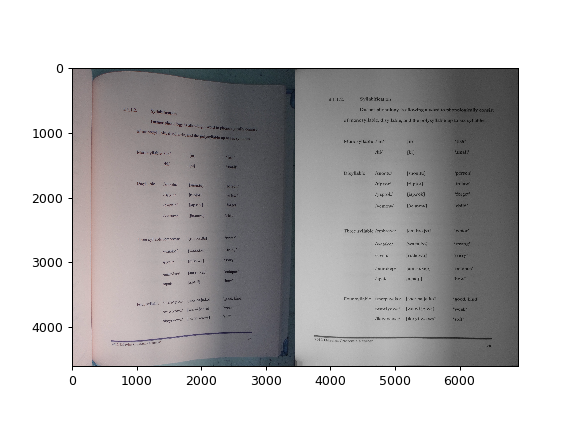

In [ ]:
plot(np.concatenate([img, thresh], axis=1))

# Example

<IPython.core.display.Javascript object>


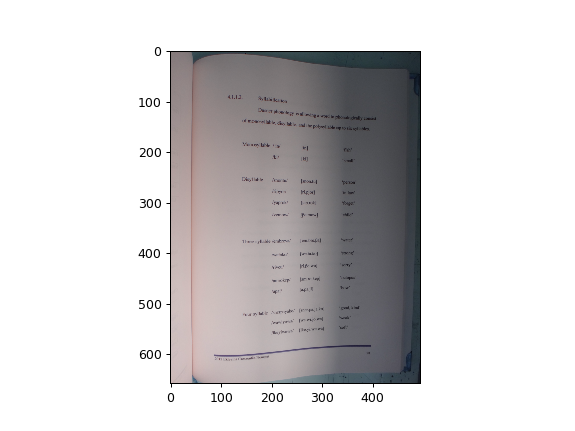

In [ ]:
img = cv2.imread('../test_data/warped_page.jpg')
small = resize_to_screen(img)
plot(small)

### preprocess (get mask)

<IPython.core.display.Javascript object>


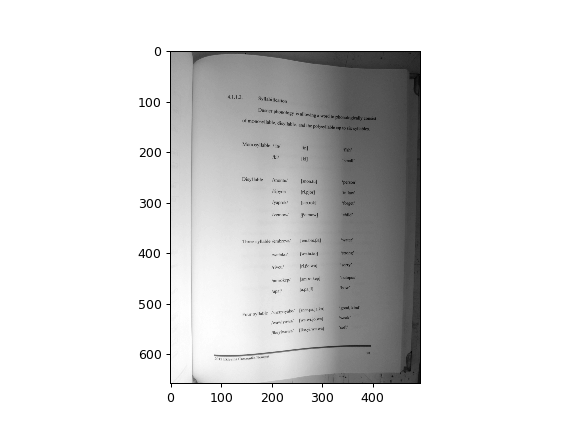

In [ ]:
sgray = cv2.cvtColor(small, cv2.COLOR_RGB2GRAY)
plot(sgray)

<IPython.core.display.Javascript object>


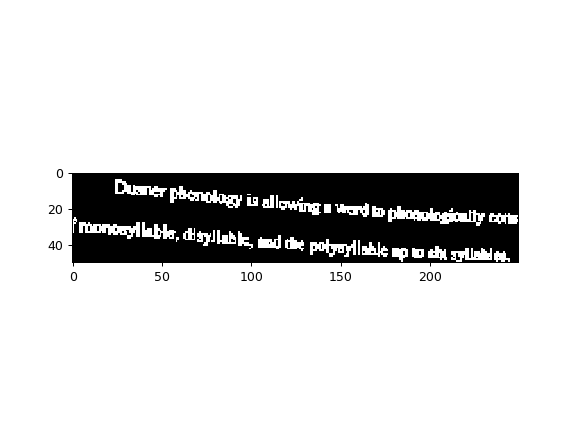

In [ ]:
window_size = 55 # window size for adaptive threshold in reduced px
maxValue = 255 # result: either 0 or 255
C = 6 # Constant subtracted from the mean
mask = cv2.adaptiveThreshold(sgray, maxValue, cv2.ADAPTIVE_THRESH_MEAN_C,
                             cv2.THRESH_BINARY_INV, window_size, C)
plot(mask[110:160 , 150:400])

<IPython.core.display.Javascript object>


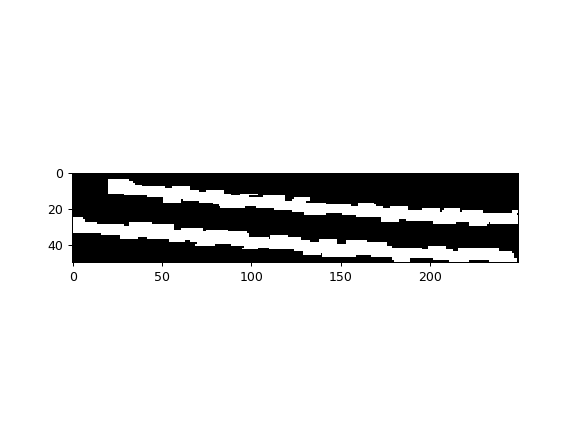

In [ ]:
mask = cv2.dilate(mask, np.ones((1,9), dtype=np.uint8))
plot(mask[110:160 , 150:400])

<IPython.core.display.Javascript object>


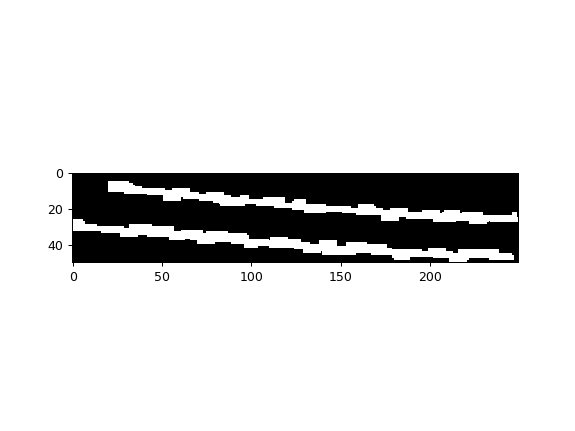

In [ ]:
mask = cv2.erode(mask, np.ones((3,1), dtype=np.uint8))
plot(mask[110:160 , 150:400])

[[ 50  20]
 [ 50 638]
 [444 638]
 [444  20]]


<IPython.core.display.Javascript object>


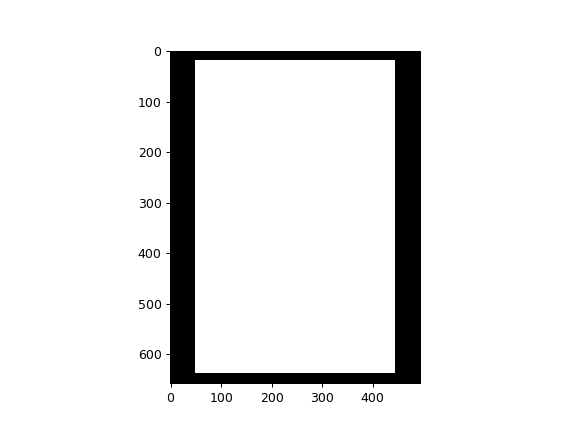

<IPython.core.display.Javascript object>


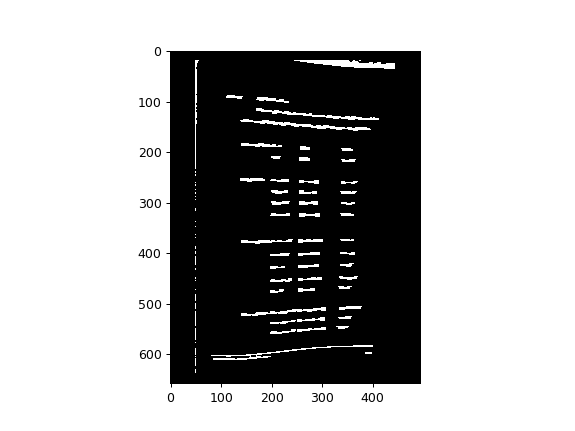

In [ ]:
pagemask, page_outline = get_page_extents(small)
print(page_outline)
plot(pagemask)

mask = np.minimum(mask, pagemask)
plot(mask)

### contours

In [ ]:
%matplotlib inline

(197, 552, 52, 10)


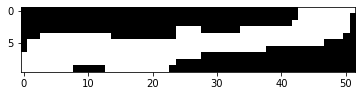

(251, 548, 58, 10)


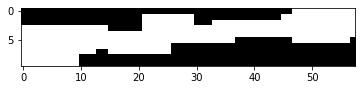

(329, 545, 26, 6)


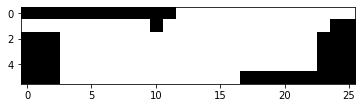

In [ ]:
cinfo_list = get_contours(mask)

for c in cinfo_list[:3]:
    print(c.rect) # where in image
    plot(c.mask) # mas of contours

In [ ]:
%matplotlib notebook

In [ ]:
CCOLORS = dewarp_config['CCOLORS']
def visualize_contours(small, cinfo_list):
    regions = np.zeros_like(small)
    for j, cinfo in enumerate(cinfo_list):
        cv2.drawContours(regions, [cinfo.contour], 0, CCOLORS[j % len(CCOLORS)], -1)
    mask = (regions.max(axis=2) != 0)
    display = small.copy()
    display[mask] = (display[mask]/2) + (regions[mask]/2)
    for j, cinfo in enumerate(cinfo_list):
        color = CCOLORS[j % len(CCOLORS)]
        color = tuple([c/4 for c in color])
        cv2.circle(display, fltp(cinfo.center), 3, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.line(display, fltp(cinfo.point0), fltp(cinfo.point1), (255, 255, 255), 1, cv2.LINE_AA)
    plot(display)

<IPython.core.display.Javascript object>


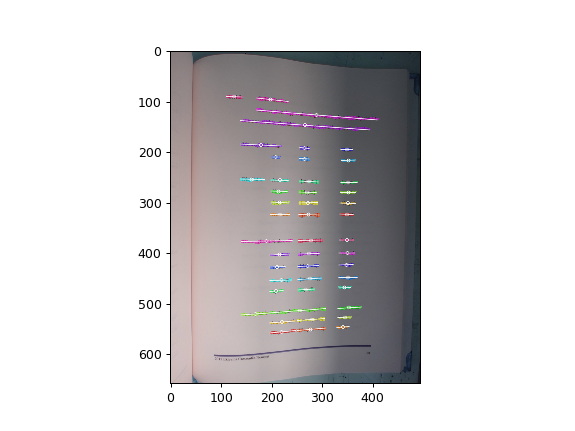

In [ ]:
visualize_contours(small, cinfo_list)

### spans

In [ ]:
def visualize_spans(small, pagemask, spans):
    regions = np.zeros_like(small)
    for i, span in enumerate(spans):
        contours = [cinfo.contour for cinfo in span]
        cv2.drawContours(regions, contours, -1, CCOLORS[i*3 % len(CCOLORS)], -1)
    mask = (regions.max(axis=2) != 0)
    display = small.copy()
    display[mask] = (display[mask]/2) + (regions[mask]/2)
    display[pagemask == 0] = display[pagemask == 0] / 4.
    plot(display)

<IPython.core.display.Javascript object>


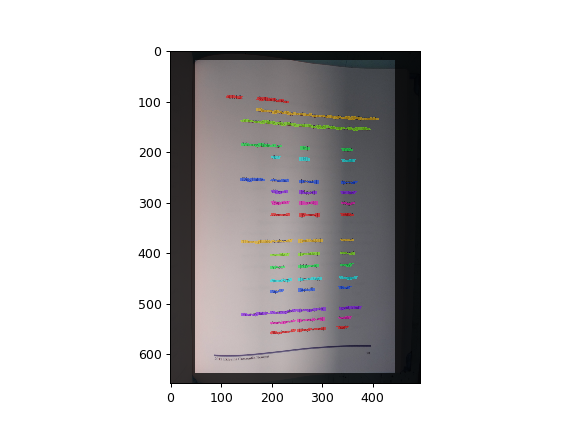

In [ ]:
spans = assemble_spans(small, pagemask, cinfo_list) # list of spans (1 span = list of contours)

# if len(spans) < 3: print('not a lot of horizontal text lines, better use cv2.adaptiveThreshold w/ C~=25')
# if len(spans) < 1: return None

visualize_spans(small, pagemask, spans)

In [ ]:
span_points = sample_spans(small.shape, spans) # [P,1,2]
print('got', len(spans), 'spans')
print('with', sum([len(pts) for pts in span_points]), 'points.')

got 17 spans
with 140 points.


In [ ]:
corners, ycoords, xcoords = keypoints_from_samples(small, pagemask, page_outline, span_points) # corners of min/max h/w samples

In [ ]:
def visualize_span_points(small, span_points, corners):
    display = small.copy()
    for i, points in enumerate(span_points):
        points = norm2pix(small.shape, points, False)
        mean, small_evec = cv2.PCACompute(points.reshape((-1, 2)), None, maxComponents=1)
        dps = np.dot(points.reshape((-1, 2)), small_evec.reshape((2, 1)))
        dpm = np.dot(mean.flatten(), small_evec.flatten())
        point0 = mean + small_evec * (dps.min()-dpm)
        point1 = mean + small_evec * (dps.max()-dpm)
        for point in points:
            cv2.circle(display, fltp(point), 3, CCOLORS[i % len(CCOLORS)], -1, cv2.LINE_AA)
        cv2.line(display, fltp(point0), fltp(point1), (255, 255, 255), 1, cv2.LINE_AA)
    cv2.polylines(display, [norm2pix(small.shape, corners, True)], True, (255, 255, 255))
    plot(display)

<IPython.core.display.Javascript object>


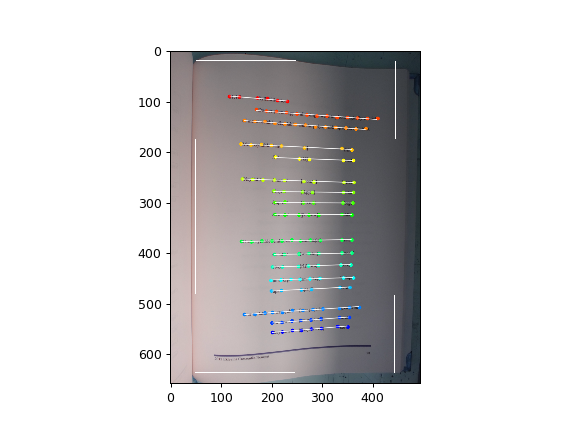

In [ ]:
visualize_span_points(small, span_points, corners)

### optimize

In [ ]:
rough_dims, span_counts, params = get_default_params(corners, ycoords, xcoords)

In [ ]:
dstpoints = np.vstack((corners[0].reshape((1, 1, 2)),) + tuple(span_points))

In [ ]:
keypoint_index = make_keypoint_index(span_counts)

<IPython.core.display.Javascript object>


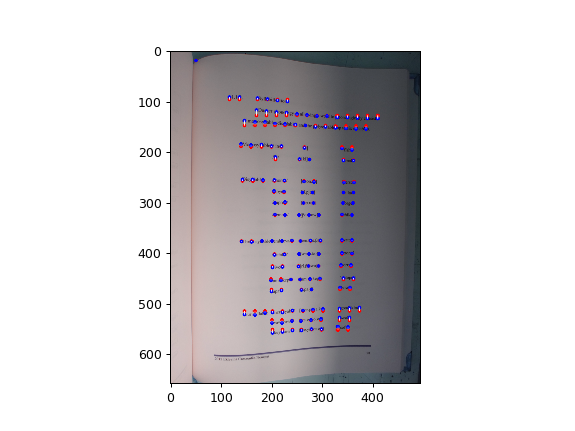

In [ ]:
# BEFORE
projpts = project_keypoints(params, keypoint_index)
display = draw_correspondences(small, dstpoints, projpts)
plot(display)

In [ ]:
params = optimize_params(small, dstpoints, span_counts, params)

<IPython.core.display.Javascript object>


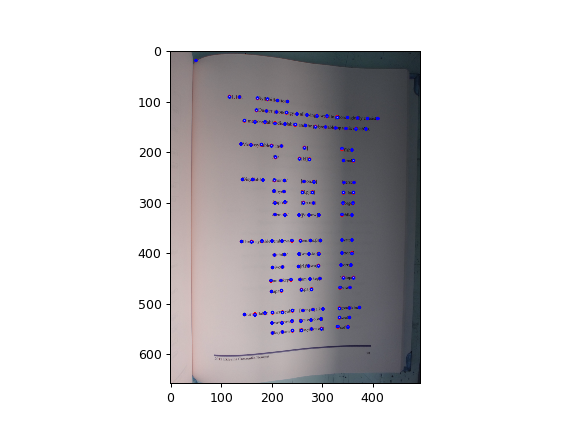

In [ ]:
# AFTER
projpts = project_keypoints(params, keypoint_index)
display = draw_correspondences(small, dstpoints, projpts)
plot(display)

### output

In [ ]:
page_dims = get_page_dims(corners, rough_dims, params)

In [ ]:
thresh = remap_image(img, small, page_dims, params)

<IPython.core.display.Javascript object>


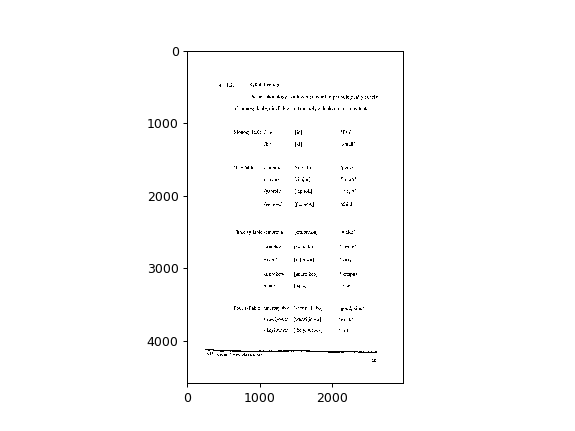

In [ ]:
height = small.shape[0]
width = int(round(height * float(thresh.shape[1])/thresh.shape[0]))
display = cv2.resize(thresh, (width, height), interpolation=cv2.INTER_AREA)
plot(thresh)

In [ ]:
print(thresh.shape, img.shape)

(4592, 2976) (4608, 3456, 3)


## Times

In [ ]:
img = cv2.imread('../test_data/warped_page.jpg')

In [ ]:
%%timeit
t1 = dewarp_image(img)

4.47 s ± 27.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Preprocess dataset

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def convert_images(IMAGES_DIR, OUT_DIR):
    total = 0
    for fn in tqdm(os.listdir(IMAGES_DIR), total=len(os.listdir(IMAGES_DIR))):
        im_fn = os.path.join(IMAGES_DIR, fn)
        out_fn = os.path.join(OUT_DIR, fn)
        img = cv2.imread(im_fn)
        sgray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        window_size = 55 # window size for adaptive threshold in reduced px
        maxValue = 255 # result: either 0 or 255
        C = 25 # Constant subtracted from the mean
        mask = cv2.adaptiveThreshold(sgray, maxValue, cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY, window_size, C)
        img = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        cv2.imwrite(out_fn, img)
#         try: thresh = dewarp_image(img)
#         except: thresh = None
#         if thresh is None:
#             cv2.imwrite(out_fn, img)
#             total += 1
#         else: cv2.imwrite(out_fn, thresh)
    print('total bad:', total)

In [ ]:
OUT_DIR, IMAGES_DIR = '../data/sroie2019/train_img_processed', '../data/sroie2019/train_img'
convert_images(IMAGES_DIR, OUT_DIR)


total bad: 0


<IPython.core.display.Javascript object>


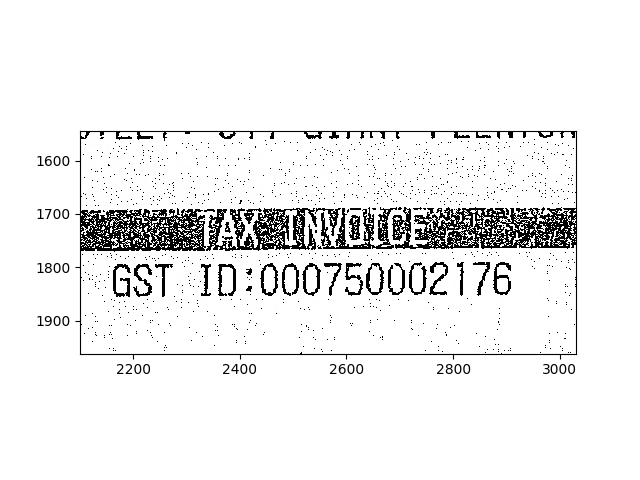

In [ ]:
img = cv2.imread('../data/sroie2019/test_img/X51007846358.jpg')
plot(img)

<IPython.core.display.Javascript object>


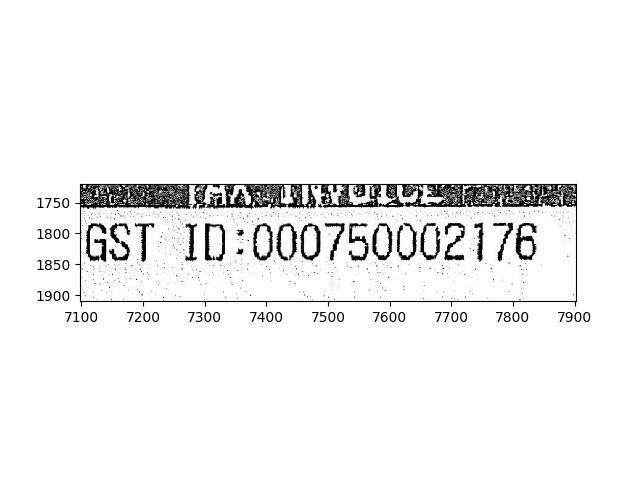

In [ ]:
# img = cv2.imread('./examples/warped_page.jpg')

img = cv2.imread('../data/sroie2019/test_img/X51007846358.jpg')
thresh = dewarp_image(img)
plot(np.concatenate([img, thresh], axis=1))